In [1]:
import copy
from collections import defaultdict

import gymnasium
from gymnasium.envs.toy_text.cliffwalking import (
    UP, RIGHT, DOWN, LEFT, POSITION_MAPPING
)
import numpy as np
import tqdm
from IPython import display
from PIL import Image, ImageEnhance
import moviepy.editor as mpy
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

In [2]:
class CliffWalkingEnv(gymnasium.Wrapper):
    def __init__(self, random_init_state=False, max_episode_steps=1000, 
                 render_mode="rgb_array", **kwargs):
        env = gymnasium.make(
            "CliffWalking-v1",
            max_episode_steps=max_episode_steps,
            render_mode=render_mode,
            **kwargs
        )
        super().__init__(env)

        self.nS = self.env.get_wrapper_attr('nS')
        self.nA = self.env.get_wrapper_attr('nA')
        self.shape = self.env.get_wrapper_attr('shape')

        # The original transition probabilities for absorbing states are not correct.
        P = {}
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            P[s] = {a: [] for a in range(self.nA)}
            P[s][UP] = self._calculate_transition_prob(position, UP)
            P[s][RIGHT] = self._calculate_transition_prob(position, RIGHT)
            P[s][DOWN] = self._calculate_transition_prob(position, DOWN)
            P[s][LEFT] = self._calculate_transition_prob(position, LEFT)
        self.env.set_wrapper_attr('P', P)

        if random_init_state:
            initial_state_distrib = np.ones(self.nS)
            cliff_positions = np.asarray(np.where(env.get_wrapper_attr('_cliff')))
            cliff_states = np.ravel_multi_index(cliff_positions, self.shape)
            initial_state_distrib[cliff_states] = 0.0
            initial_state_distrib[47] = 0.0
            initial_state_distrib /= np.sum(initial_state_distrib, keepdims=True)
            self.env.set_wrapper_attr('initial_state_distrib', initial_state_distrib)

        # Calculate transition probabilities and rewards
        rewards = np.full((self.nS, self.nA, self.nS), np.nan)
        transition_probs = np.zeros((self.nS, self.nA, self.nS))
        masks = np.zeros((self.nS, self.nA, self.nS))
        for state in range(self.nS):
            for action in range(self.nA):
                _, next_state, reward, terminated = self.env.get_wrapper_attr('P')[state][action][0]
                rewards[state, action, next_state] = reward
                transition_probs[state, action, next_state] += 1.0
                masks[state, action, next_state] = float(not terminated)
        transition_probs /= np.sum(transition_probs, axis=-1, keepdims=True)
        assert np.all(np.sum(transition_probs, axis=-1) == 1.0)
        reward_max, reward_min = np.nanmax(rewards), np.nanmin(rewards)
        rewards[np.isnan(rewards)] = reward_min
        assert np.all((reward_min <= rewards) & (rewards <= reward_max))

        self._orig_reward_min, self._orig_reward_max = reward_min, reward_max
        self.orig_rewards = rewards
        self.rewards = (rewards - reward_min) / (reward_max - reward_min)
        self.transition_probs = transition_probs
        self.masks = masks

    def _calculate_transition_prob(self, current, move):
        """Determine the outcome for an action. Transition Prob is always 1.0.
        
        The original transition probabilities for absorbing states are not correct.
        """
        if not self.env.get_wrapper_attr('is_slippery'):
            deltas = [POSITION_MAPPING[move]]
        else:
            deltas = [
                POSITION_MAPPING[act] for act in [(move - 1) % 4, move, (move + 1) % 4]
            ]
        outcomes = []

        # the single absorbing state is the goal
        goal_position = np.asarray([self.shape[0] - 1, self.shape[1] - 1])
        goal_state = np.ravel_multi_index(goal_position, self.shape)
        current_position = np.array(current)
        current_state = np.ravel_multi_index(tuple(current_position), self.shape)
        for delta in deltas:
            if current_state == goal_state:
                new_state = current_state
                reward = 0
                is_terminated = True
            else:
                new_position = current_position + np.array(delta)
                new_position = self.env.get_wrapper_attr('_limit_coordinates')(new_position).astype(int)
                new_state = np.ravel_multi_index(tuple(new_position), self.shape)
                if self.env.get_wrapper_attr('_cliff')[tuple(new_position)]:
                    reward = -100
                    new_state = self.env.get_wrapper_attr('start_state_index')
                else:
                    reward = -1
                is_terminated = (new_state == goal_state)
            outcomes.append((1 / len(deltas), new_state, reward, is_terminated))
        return outcomes

    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        self.env.set_wrapper_attr('start_state_index', obs)

        return obs, info

    def step(self, action):
        obs, orig_reward, terminated, truncated, info = super().step(action)
        reward = (orig_reward - self._orig_reward_min) / (self._orig_reward_max - self._orig_reward_min)

        return obs, reward, terminated, truncated, info


In [3]:
# collect dataset
discount = 0.95
max_episode_steps = 100
env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)

# uniform behavioral policy
behavioral_policy = np.ones([env.nS, env.nA]) / env.nA

dataset = defaultdict(list)

# dataset size = 100K
# num_episodes = 5_250
num_episodes = 1000
num_transitions = 0
for _ in tqdm.trange(num_episodes):
    # done = False
    obs, info = env.reset()
    # while not done:
    for _ in range(max_episode_steps):
        action = np.random.choice(np.arange(env.nA), p=behavioral_policy[obs])
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        num_transitions += 1
        dataset['observations'].append(obs)
        dataset['actions'].append(action)
        dataset['rewards'].append(reward)
        dataset['next_observations'].append(next_obs)
        dataset['masks'].append(not terminated)  # for absorbing states
        dataset['terminals'].append(truncated)  # for the end of trajectories
        
        obs = next_obs

for k, v in dataset.items():
    if k in ['observations', 'actions', 'next_observations']:
        dtype = np.int32
    elif k == 'terminals':
        dtype = bool
    else:
        dtype = np.float32
    dataset[k] = np.array(v, dtype=dtype)

print("num of total transitions {}".format(num_transitions))

100%|██████████| 1000/1000 [00:03<00:00, 264.18it/s]

num of total transitions 100000


In [4]:
print(np.sum(dataset['next_observations'] == 47))

7202


In [5]:
# value iteration to find the optimal Q
rewards = env.rewards
transition_probs = env.transition_probs
# masks = env.masks

# value iteration to find the optimal Q in the original MDP using gamma
opt_q = np.zeros([env.nS, env.nA], dtype=np.float32)
for _ in range(10_000):
  opt_q = (1 - discount) * np.sum(transition_probs * rewards, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q, axis=-1))
opt_v = np.max(opt_q, axis=-1)

# deterministic optimal policy
opt_policy = np.zeros([env.nS, env.nA])
opt_policy[np.arange(env.nS), np.argmax(opt_q, axis=-1)] = 1.0

# value iteration to find the optimal Q in the original MDP using gamma ** 2
opt_q_square_discount = np.zeros([env.nS, env.nA], dtype=np.float32)
for _ in range(10_000):
  opt_q_square_discount = (1 - discount ** 2) * np.sum(transition_probs * rewards, axis=-1) + discount ** 2 * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q_square_discount, axis=-1))

# value iteration to find the behavioral Q
behavioral_q = np.zeros([env.nS, env.nA], dtype=np.float32)
for _ in range(10_000):
  behavioral_q = (1 - discount) * np.sum(transition_probs * rewards, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.sum(behavioral_policy * behavioral_q, axis=-1))
behavioral_v = np.sum(behavioral_policy * behavioral_q, axis=-1)

In [6]:
print("optimal q and optimal policy: ")
print(opt_q)
print(opt_policy)

print("behavioral q: ")
print(behavioral_q)

optimal q and optimal policy: 
[[0.99463291 0.99487675 0.99487675 0.99463291]
 [0.99487675 0.99513342 0.99513342 0.99463291]
 [0.99513342 0.9954036  0.9954036  0.99487675]
 [0.9954036  0.995688   0.995688   0.99513342]
 [0.995688   0.99598737 0.99598737 0.9954036 ]
 [0.99598737 0.99630249 0.99630249 0.995688  ]
 [0.99630249 0.9966342  0.9966342  0.99598737]
 [0.9966342  0.99698337 0.99698337 0.99630249]
 [0.99698337 0.99735092 0.99735092 0.9966342 ]
 [0.99735092 0.99773781 0.99773781 0.99698337]
 [0.99773781 0.99814506 0.99814506 0.99735092]
 [0.99814506 0.99814506 0.99857375 0.99773781]
 [0.99463291 0.99513342 0.99513342 0.99487675]
 [0.99487675 0.9954036  0.9954036  0.99487675]
 [0.99513342 0.995688   0.995688   0.99513342]
 [0.9954036  0.99598737 0.99598737 0.9954036 ]
 [0.995688   0.99630249 0.99630249 0.995688  ]
 [0.99598737 0.9966342  0.9966342  0.99598737]
 [0.99630249 0.99698337 0.99698337 0.99630249]
 [0.9966342  0.99735092 0.99735092 0.9966342 ]
 [0.99698337 0.99773781 0.997

In [7]:
def get_video(renders):
    """Return a Weights & Biases video.

    It takes a list of videos and reshapes them into a single video with the specified number of columns.

    Args:
        renders: List of videos. Each video should be a numpy array of shape (t, h, w, c).
        n_cols: Number of columns for the reshaped video. If None, it is set to the square root of the number of videos.
    """
    # Pad videos to the same length.
    max_length = max([len(render) for render in renders])
    for i, render in enumerate(renders):
        assert render.dtype == np.uint8

        # Decrease brightness of the padded frames.
        final_frame = render[-1]
        final_image = Image.fromarray(final_frame)
        enhancer = ImageEnhance.Brightness(final_image)
        final_image = enhancer.enhance(0.5)
        final_frame = np.array(final_image)

        pad = np.repeat(final_frame[np.newaxis, ...], max_length - len(render), axis=0)
        renders[i] = np.concatenate([render, pad], axis=0)

        # Add borders.
        renders[i] = np.pad(renders[i], ((0, 0), (1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)
    renders = np.array(renders)  # (n, t, h, w, c)

    return renders

In [8]:
# evaluation the optimal pi
max_episode_steps = 100
eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)

num_episodes = 6
successes = []
renders = []
for _ in tqdm.trange(num_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, info = eval_env.reset()
    render = eval_env.render().copy()
    while not done:
        action = np.random.choice(np.arange(eval_env.nA), p=opt_policy[obs])
        next_obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        next_render = eval_env.render().copy()
        
        traj_dataset['observations'].append(obs)
        traj_dataset['actions'].append(action)
        traj_dataset['rewards'].append(reward)
        traj_dataset['next_observations'].append(next_obs)
        traj_dataset['renders'].append(render)
        
        obs = next_obs
        render = next_render
    traj_dataset['renders'].append(render)  # append the last frame
    
    successes.append(47 in traj_dataset['next_observations'])
    renders.append(np.asarray(traj_dataset['renders']))

sr = np.mean(successes)
print("success rate = {}".format(sr))

videos = get_video(renders)

fps = 15
num_rows = 2
num_cols = 3
clip_array = []
for row in range(num_rows):
    clip_row = []
    for col in range(num_cols):
        idx = row * num_cols + col
        
        clip = mpy.ImageSequenceClip(list(videos[idx]), fps=fps)
        clip_row.append(clip)
    clip_array.append(clip_row)

clip_array = mpy.clips_array(clip_array)
clip_array.ipython_display(fps=fps, loop=True, autoplay=True)


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 28.70it/s]


success rate = 1.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### Augmented env

In [20]:
class AugmentedCliffWalkingEnv(CliffWalkingEnv):
    def __init__(self, discount=0.99, random_init_state=False, max_episode_steps=1000,
                 render_mode="rgb_array", **kwargs):
        self.discount = discount

        super().__init__(random_init_state, max_episode_steps, render_mode=render_mode, **kwargs)

        # add s+ and s- into the state space
        self.nS += 2
        self.observation_space = gymnasium.spaces.Discrete(self.nS)

        rewards = np.full((self.nS, self.nA, self.nS), -1.0)
        transition_probs = np.zeros((self.nS, self.nA, self.nS))
        masks = np.zeros((self.nS, self.nA, self.nS))

        # transiting into s+ and staying at s+ give 0.0 reward, otherwise the reward is -1.
        # rewards[..., self.nS - 2] = 0.0
        rewards[self.nS - 2] = 0.0
        assert np.all((-1.0 <= rewards) & (rewards <= 1.0))

        transition_probs[:self.nS - 2, :, :self.nS - 2] = discount * self.transition_probs
        transition_probs[:self.nS - 2, :, self.nS - 2] = (1.0 - discount) * np.sum(
            self.rewards * self.transition_probs, axis=-1)
        transition_probs[:self.nS - 2, :, self.nS - 1] = (1.0 - discount) * (1.0 - np.sum(
            self.rewards * self.transition_probs, axis=-1))
        transition_probs[self.nS - 2, :, self.nS - 2] = 1.0
        transition_probs[self.nS - 1, :, self.nS - 1] = 1.0
        assert np.all(np.sum(transition_probs, axis=-1) == 1.0)

        # (chongyi): the original absorbing states becomes non-absorbing states
        masks[:self.nS - 2, :, :self.nS - 2] = np.ones_like(self.masks)
        masks[..., self.nS - 2] = 0.0
        masks[..., self.nS - 1] = 0.0
        masks[self.nS - 2] = 0.0
        masks[self.nS - 1] = 0.0

        self.aug_rewards = rewards
        self.aug_transition_probs = transition_probs
        self.aug_masks = masks

        self.last_aug_s = None

    def reset(self, **kwargs):
        obs, info = super().reset(**kwargs)
        self.last_aug_s = obs

        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)

        # augmented transitions
        # aug_reward = -1.0
        # aug_info = {"prob": 1}
        # aug_terminated = True
        # if self.last_aug_s == self.nS - 2:
        #     aug_obs = int(self.nS - 2)
        #     aug_reward = 0.0
        # elif self.last_aug_s == self.nS - 1:
        #     aug_obs = int(self.nS - 1)
        # else:
        #     if np.random.rand() < self.discount:
        #         aug_obs = obs
        #         aug_info = info
        #         aug_terminated = False
        #     else:
        #         if np.random.rand() < reward:
        #             aug_obs = int(self.nS - 2)
        #         else:
        #             aug_obs = int(self.nS - 1)
        # self.last_aug_s = aug_obs
        
        # goal-conditioned transitions
        aug_obs = obs
        aug_reward = -1.0 if obs != self.nS - 3 else 0.0
        aug_terminated = terminated
        aug_info = info

        return aug_obs, aug_reward, aug_terminated, truncated, aug_info


In [21]:
# collect dataset
discount = 0.95
max_episode_steps = 100
aug_env = AugmentedCliffWalkingEnv(discount=discount, random_init_state=True, max_episode_steps=max_episode_steps)

# optimal behavioral policy with noise
behavioral_policy = np.ones([aug_env.nS, aug_env.nA]) / aug_env.nA

aug_dataset = defaultdict(list)

# num_episodes = 5_250
num_episodes = 1_000
num_transitions = 0
for _ in tqdm.trange(num_episodes):
    done = False
    obs, info = aug_env.reset()
    # while not done:
    for _ in range(max_episode_steps):
        action = np.random.choice(np.arange(aug_env.nA), p=behavioral_policy[obs])
        next_obs, reward, terminated, truncated, info = aug_env.step(action)
        done = terminated or truncated
        
        num_transitions += 1
        aug_dataset['observations'].append(obs)
        aug_dataset['actions'].append(action)
        aug_dataset['rewards'].append(reward)
        aug_dataset['next_observations'].append(next_obs)
        aug_dataset['masks'].append(not terminated)  # for absorbing states
        # aug_dataset['terminals'].append(done)  # for the end of trajectori
        aug_dataset['terminals'].append(truncated)  # for the end of trajectori
        
        obs = next_obs

for k, v in aug_dataset.items():
    if k in ['observations', 'actions', 'next_obervations']:
        dtype = np.int32
    # elif k in ['masks', 'terminals']:
    #     dtype = bool
    else:
        dtype = np.float32
    aug_dataset[k] = np.array(v, dtype=dtype)

print("num of augmented transitions: {}".format(num_transitions))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 290.02it/s]

num of augmented transitions: 100000


In [22]:
# print(aug_dataset['observations'][112])
print(np.sum(aug_dataset['next_observations'] == 47))
print(np.sum(aug_dataset['next_observations'] == 48))
print(np.sum(aug_dataset['next_observations'] == 49))

7695
0
0


In [23]:
# value iteration to find the optimal discounted state occupancy measure in the GCMDP using gamma
rewards = aug_env.aug_rewards
transition_probs = aug_env.aug_transition_probs
# masks = aug_env.aug_masks

opt_d_sa = np.zeros([aug_env.nS, aug_env.nA, aug_env.nS], dtype=np.float32)
for _ in range(10_000):
  opt_a = np.argmax(opt_d_sa[..., aug_env.nS - 2], axis=-1)
  opt_pi = np.zeros([aug_env.nS, aug_env.nA])
  opt_pi[np.arange(aug_env.nS), opt_a] = 1.
  opt_d_sa = (1 - discount) * np.eye(aug_env.nS)[:, None] + discount * np.einsum('ijk,kl->ijl', transition_probs, np.sum(opt_d_sa * opt_pi[..., None], axis=1))

opt_a = np.argmax(opt_d_sa[..., aug_env.nS - 2], axis=-1)
opt_pi = np.zeros((aug_env.nS, aug_env.nA))
opt_pi[np.arange(aug_env.nS), opt_a] = 1.

opt_d_s = np.sum(opt_d_sa * opt_pi[..., None], axis=1)

In [24]:
print("scaled optimal d_gamma(s+ | s, a) and optimal policy: ")
scaled_opt_d_sa_splus = opt_d_sa[:aug_env.nS - 2, :, aug_env.nS - 2] * (1 + discount) / discount
print(scaled_opt_d_sa_splus)
print(opt_pi)

print("optimal Q_gamma^2(s, a): ")
print(opt_q_square_discount)

assert np.allclose(scaled_opt_d_sa_splus, opt_q_square_discount)

scaled optimal d_gamma(s+ | s, a) and optimal policy: 
[[0.99214639 0.99237827 0.99237827 0.99214639]
 [0.99237827 0.9926352  0.9926352  0.99214639]
 [0.9926352  0.99291989 0.99291989 0.99237827]
 [0.99291989 0.99323534 0.99323534 0.9926352 ]
 [0.99323534 0.99358486 0.99358486 0.99291989]
 [0.99358486 0.99397214 0.99397214 0.99323534]
 [0.99397214 0.99440127 0.99440127 0.99358486]
 [0.99440127 0.99487675 0.99487675 0.99397214]
 [0.99487675 0.9954036  0.9954036  0.99440127]
 [0.9954036  0.99598737 0.99598737 0.99487675]
 [0.99598737 0.9966342  0.9966342  0.9954036 ]
 [0.9966342  0.9966342  0.99735092 0.99598737]
 [0.99214639 0.9926352  0.9926352  0.99237827]
 [0.99237827 0.99291989 0.99291989 0.99237827]
 [0.9926352  0.99323534 0.99323534 0.9926352 ]
 [0.99291989 0.99358486 0.99358486 0.99291989]
 [0.99323534 0.99397214 0.99397214 0.99323534]
 [0.99358486 0.99440127 0.99440127 0.99358486]
 [0.99397214 0.99487675 0.99487675 0.99397214]
 [0.99440127 0.9954036  0.9954036  0.99440127]
 [0.9

In [25]:
# value iteration to compute the optimal single goal-conditioned Q in the GCMDP using gamma
rewards = aug_env.aug_rewards
transition_probs = aug_env.aug_transition_probs
# masks = aug_env.aug_masks

opt_gc_q = np.zeros([aug_env.nS, aug_env.nA], dtype=np.float32)
for _ in range(10_000):
  opt_gc_q = (1 - discount) * np.sum(rewards * transition_probs, axis=-1) + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_gc_q, axis=-1))
scaled_opt_gc_q = (opt_gc_q[:aug_env.nS - 2] + 1) * (1 + discount) / discount

assert np.allclose(scaled_opt_d_sa_splus, scaled_opt_gc_q)
assert np.allclose(opt_q_square_discount, scaled_opt_gc_q)

print("optimal Q_gamma^2(s, a): ")
print(opt_q_square_discount)

print("scaled optimal goal-conditioned Q: ")
print(scaled_opt_gc_q)

optimal Q_gamma^2(s, a): 
[[0.99214639 0.99237827 0.99237827 0.99214639]
 [0.99237827 0.9926352  0.9926352  0.99214639]
 [0.9926352  0.99291989 0.99291989 0.99237827]
 [0.99291989 0.99323534 0.99323534 0.9926352 ]
 [0.99323534 0.99358486 0.99358486 0.99291989]
 [0.99358486 0.99397214 0.99397214 0.99323534]
 [0.99397214 0.99440127 0.99440127 0.99358486]
 [0.99440127 0.99487675 0.99487675 0.99397214]
 [0.99487675 0.9954036  0.9954036  0.99440127]
 [0.9954036  0.99598737 0.99598737 0.99487675]
 [0.99598737 0.9966342  0.9966342  0.9954036 ]
 [0.9966342  0.9966342  0.99735092 0.99598737]
 [0.99214639 0.9926352  0.9926352  0.99237827]
 [0.99237827 0.99291989 0.99291989 0.99237827]
 [0.9926352  0.99323534 0.99323534 0.9926352 ]
 [0.99291989 0.99358486 0.99358486 0.99291989]
 [0.99323534 0.99397214 0.99397214 0.99323534]
 [0.99358486 0.99440127 0.99440127 0.99358486]
 [0.99397214 0.99487675 0.99487675 0.99397214]
 [0.99440127 0.9954036  0.9954036  0.99440127]
 [0.99487675 0.99598737 0.99598737

#### Utils

In [26]:
def sample_batch(batch_size):
    dataset_size = len(dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], dataset)
    
    return batch

In [27]:
(terminal_locs,) = np.nonzero(aug_dataset['terminals'] > 0)
assert terminal_locs[-1] == (len(aug_dataset['observations']) - 1)

def sample_augmented_batch(batch_size, p_curgoal=0.2, p_trajgoal=0.5, relabel_reward=False):
    dataset_size = len(aug_dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], aug_dataset)
    
    final_state_idxs = terminal_locs[np.searchsorted(terminal_locs, idxs)]
    
    offsets = np.random.geometric(p=1 - discount, size=batch_size)  # in [1, inf)
    traj_goal_idxs = np.minimum(idxs + offsets, final_state_idxs)
    random_goal_idxs = np.random.randint(dataset_size, size=batch_size)
    goal_idxs = np.where(
        np.random.rand(batch_size) < p_trajgoal / (1.0 - p_curgoal), traj_goal_idxs, random_goal_idxs
    )
    goal_idxs = np.where(np.random.rand(batch_size) < p_curgoal, idxs, goal_idxs)
    
    batch['goals'] = jax.tree_util.tree_map(lambda arr: arr[goal_idxs], aug_dataset['observations'])
    if relabel_reward:
        successes = np.logical_or((idxs + 1) == goal_idxs, idxs == goal_idxs).astype(float)
        batch['masks'] = 1.0 - successes
        batch['rewards'] = successes - 1  # 0 for goal and -1 for other states
    
    return batch

In [28]:
def plot_metrics(metrics, logyscale_stats=[], title=''):
  # learning curves
  nrows = np.ceil(len(metrics) / 4).astype(int)
  ncols = 4
  f, axes = plt.subplots(nrows=nrows, ncols=ncols)
  if nrows == 1:
    axes = np.array([axes])
  f.set_figheight(3 * nrows)
  f.set_figwidth(3 * ncols)

  for idx, (name, val) in enumerate(metrics.items()):
    v = np.array(val)
    if len(v) == 0:
      continue

    x, y = v[:, 0], v[:, 1]
    ax = axes[idx // 4, idx % 4]

    if 'train' in name:
      y = gaussian_filter1d(y, 100)
    ax.plot(x, y)
    if name in logyscale_stats:
      ax.set_yscale('log')
    ax.set_title(name)

    ax.grid()

  f.suptitle(title)

  return f

### Q-Learning

In [ ]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, env.nS)
    action = jax.nn.one_hot(action, env.nA)
    inputs = jnp.concatenate([obs, action], axis=-1)
    # inputs = jnp.ravel_multi_index(jnp.stack([obs, action], axis=-1).T, (env.nS, env.nA))
    # inputs = obs * env.nA + action
    # inputs = jax.nn.one_hot(inputs, env.nS * env.nA)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    # qs = nn.Dense(1,  use_bias=False)(inputs)
    
    qs = qs.squeeze(-1)

    return qs

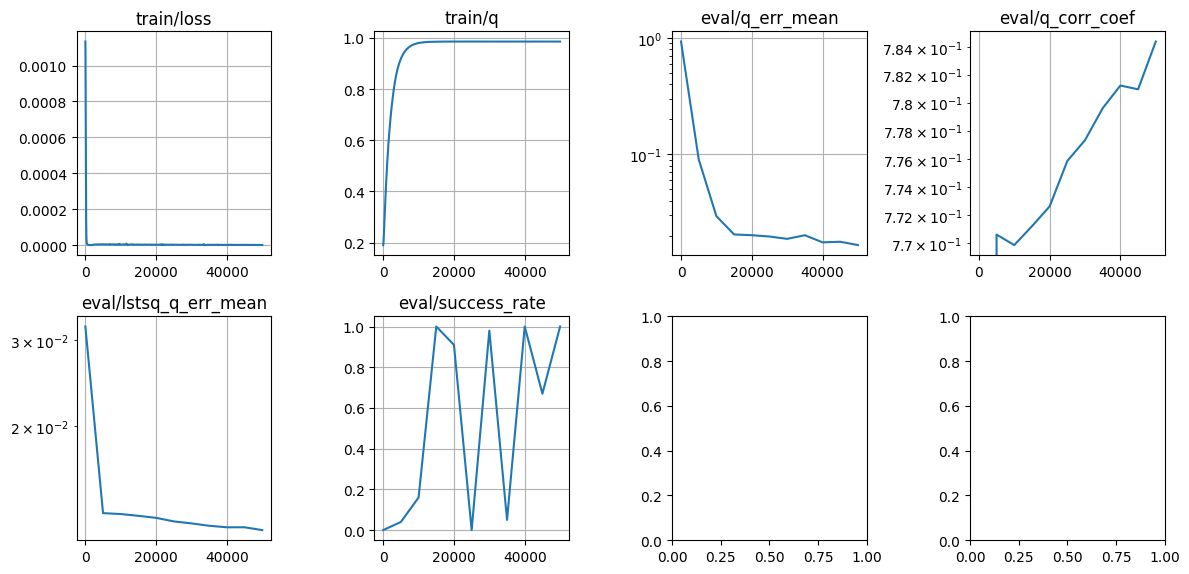

100%|██████████| 50000/50000 [01:10<00:00, 704.31it/s] 


In [19]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  
  next_observations = batch['next_observations'][:, None].repeat(env.nA, axis=1).reshape(-1)
  next_actions = jnp.arange(env.nA)[None, :].repeat(batch_size, axis=0).reshape(-1)
  next_qs = critic.apply(target_params, next_observations, next_actions)
  next_qs = next_qs.reshape([batch_size, env.nA])
  next_q = jnp.max(next_qs, axis=-1)
  target_q = (1 - discount ** 2) * batch['rewards'] + discount ** 2 * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=100, max_episode_steps=100):
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(eval_env.nS)[:, None].repeat(eval_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(eval_env.nA)[None, :].repeat(eval_env.nS, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([eval_env.nS, eval_env.nA])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, eval_env.nA)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=pi[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(env.nS)[:, None].repeat(env.nA, axis=1).reshape(-1)
  actions = jnp.arange(env.nA)[None, :].repeat(env.nS, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([env.nS, env.nA])
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [20]:
q_learning_metrics = metrics
print(q_learning_metrics['eval/q_err_mean'][-1])
print(q_learning_metrics['eval/q_corr_coef'][-1])
print(q_learning_metrics['eval/lstsq_q_err_mean'][-1])
print(q_learning_metrics['eval/success_rate'][-1])

[5.00000000e+04 1.65392086e-02]
[5.00000000e+04 7.84374118e-01]
[5.00000000e+04 1.22814393e-02]
[5.e+04 1.e+00]


### SGCQL

In [18]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action):
    obs = jax.nn.one_hot(obs, aug_env.nS)
    action = jax.nn.one_hot(action, aug_env.nA)
    inputs = jnp.concatenate([obs, action], axis=-1)
    
    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

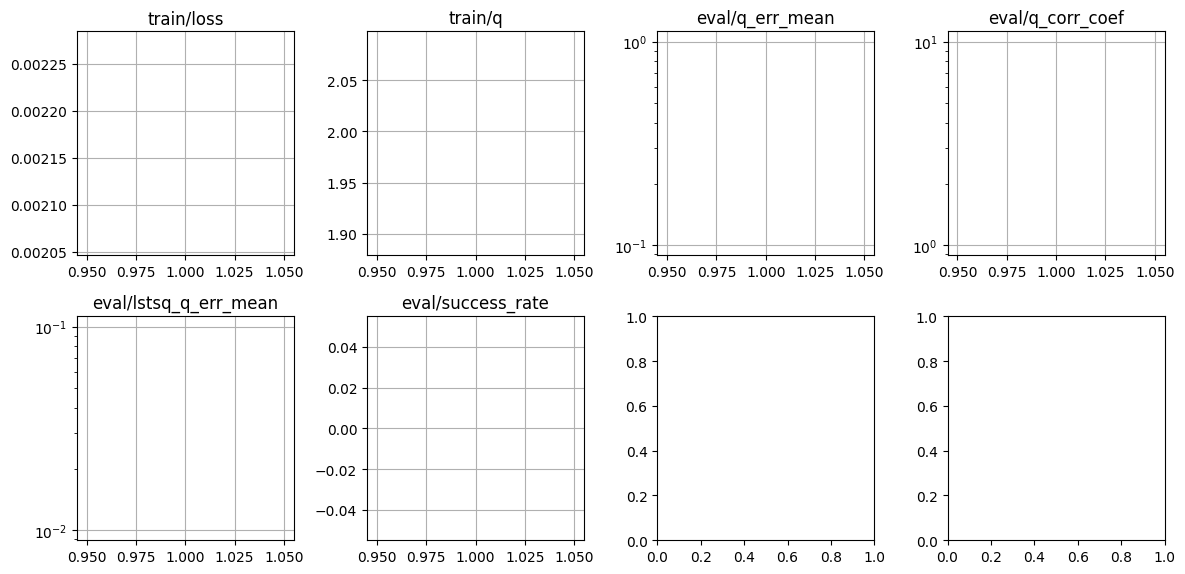

  0%|          | 175/50000 [00:07<37:07, 22.37it/s] 


ValueError: setting an array element with a sequence.

In [19]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

aug_rewards = jnp.asarray(aug_env.aug_rewards)
aug_transition_probs = jnp.asarray(aug_env.aug_transition_probs)

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'])
  
  next_observations = batch['next_observations'][:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  next_actions = jnp.arange(aug_env.nA)[None, :].repeat(batch_size, axis=0).reshape(-1)
  next_qs = critic.apply(target_params, next_observations, next_actions)
  next_qs = next_qs.reshape([batch_size, aug_env.nA])
  next_q = jnp.max(next_qs, axis=-1)
  # target_q = (1 - discount) * batch['rewards'] + discount * batch['masks'] * next_q
  target_q = (1 - discount) * batch['rewards'] + discount * next_q

  # obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  # actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
  # next_qs = critic.apply(target_params, obs, actions)
  # next_qs = next_qs.reshape([aug_env.nS, aug_env.nA])

  # # target_q = (
  # #   (1.0 - discount) * jnp.sum(aug_rewards * aug_transition_probs, axis=-1)[batch['observations'], batch['actions']]
  # #   + discount * jnp.einsum('ijk,k->ij', aug_transition_probs, jnp.max(next_qs, axis=-1))[batch['observations'], batch['actions']]
  # # )
  # target_q = (
  #   (1.0 - discount) * batch['rewards']
  #   + discount * jnp.einsum('ijk,k->ij', aug_transition_probs, jnp.max(next_qs, axis=-1))[batch['observations'], batch['actions']]
  # )

  loss = jnp.mean((q - target_q) ** 2)
  
  scaled_q = (q + 1) * (1 + discount) / discount
  
  info = {
    'loss': loss,
    'q': scaled_q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=100, max_episode_steps=100):
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions)
  q = q.reshape([aug_env.nS, aug_env.nA])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, aug_env.nA)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=pi[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
  gc_q = critic.apply(params, obs, actions)
  gc_q = gc_q.reshape([aug_env.nS, aug_env.nA])
  # q = gc_q[:env.nS]
  # q = q * (1 + discount) / discount
  # scaled_gc_q = gc_q * discount + indicators * (1 - discount)
  # scaled_gc_q = scaled_gc_q * (1 + discount) / discount
  q = (gc_q[:aug_env.nS - 2] + 1) * (1 + discount) / discount
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [ ]:
# evaluation the pi
obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
q = critic.apply(critic_params, obs, actions)
q = q.reshape([aug_env.nS, aug_env.nA])
a = jnp.argmax(q, axis=-1)
pi = jax.nn.one_hot(a, aug_env.nA)
pi = np.asarray(pi)

print("pi: ")
print(pi[11])
print(pi[23])
print(pi[35])


pi: 
[0. 0. 1. 0.]
[0. 0. 0. 1.]
[0. 0. 0. 1.]


### GCQL + HER

In [24]:
class Critic(nn.Module):
  @nn.compact
  def __call__(self, obs, action, goals):
    obs = jax.nn.one_hot(obs, aug_env.nS)
    action = jax.nn.one_hot(action, aug_env.nA)
    goals = jax.nn.one_hot(goals, aug_env.nS)
    inputs = jnp.concatenate([obs, action, goals], axis=-1)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(1),
    ])(inputs)
    
    qs = qs.squeeze(-1)

    return qs

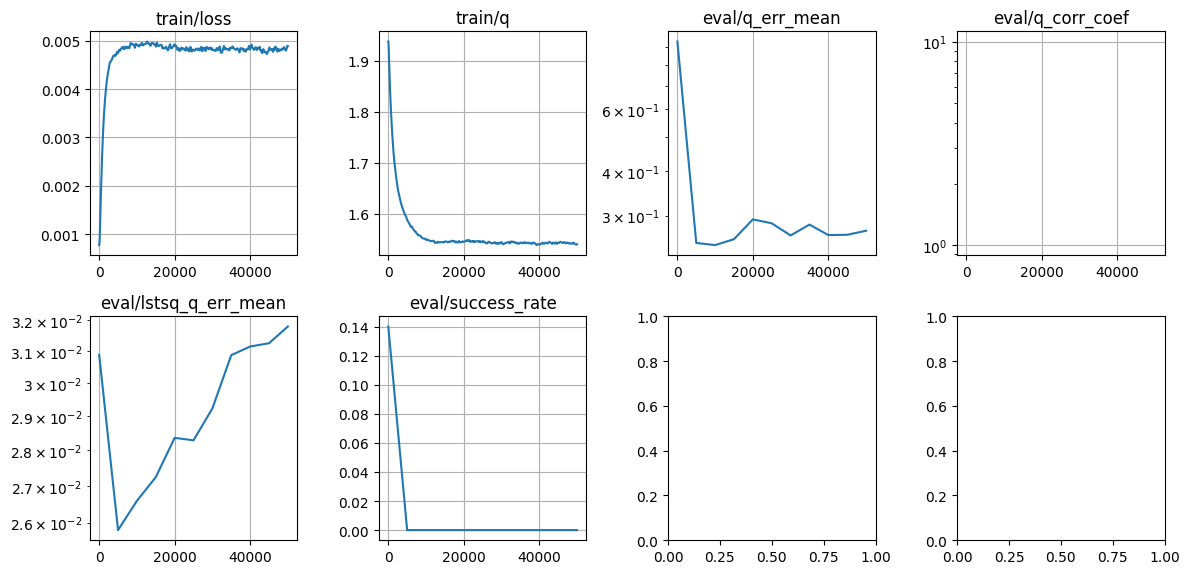

100%|██████████| 50000/50000 [01:32<00:00, 540.19it/s]


In [25]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2, relabel_reward=True)
critic = Critic()
critic_params = critic.init(critic_key, 
                            example_batch['observations'], 
                            example_batch['actions'], 
                            example_batch['goals'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  q = critic.apply(params, batch['observations'], batch['actions'], batch['goals'])
  
  next_observations = batch['next_observations'][:, None].repeat(env.nA, axis=1).reshape(-1)
  next_actions = jnp.arange(env.nA)[None, :].repeat(batch_size, axis=0).reshape(-1)
  goals = batch['goals'][:, None].repeat(env.nA, axis=1).reshape(-1)
  next_qs = critic.apply(target_params, next_observations, next_actions, goals)
  next_qs = next_qs.reshape([batch_size, env.nA])
  next_q = next_qs.max(axis=-1)
  target_q = (1 - discount) * batch['rewards'] + discount * batch['masks'] * next_q
  # target_q = (1 - discount) * batch['rewards'] + discount * next_q

  loss = jnp.mean((q - target_q) ** 2)

  # for logging
  gc_q = critic.apply(params, batch['observations'], batch['actions'], jnp.full_like(batch['goals'], (aug_env.nS - 2)))  
  scaled_gc_q = (gc_q + 1) * (1 + discount) / discount
  
  info = {
    'loss': loss,
    'q': scaled_gc_q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=100, max_episode_steps=100):
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
  q = critic.apply(params, obs, actions, jnp.full_like(obs, (aug_env.nS - 2)))
  q = q.reshape([aug_env.nS, aug_env.nA])
  a = jnp.argmax(q, axis=-1)
  pi = jax.nn.one_hot(a, aug_env.nA)
  pi = np.asarray(pi)
  
  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=pi[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
  gc_q = critic.apply(params, obs, actions, jnp.full_like(obs, (aug_env.nS - 2)))
  gc_q = gc_q.reshape([aug_env.nS, aug_env.nA])
  q = (gc_q[:aug_env.nS - 2] + 1) * (1 + discount) / discount
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size, relabel_reward=True)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/q_corr_coef', 'eval/lstsq_q_err_mean'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [26]:
gcql_her_metrics = metrics
print(gcql_her_metrics['eval/q_err_mean'][-1])
print(gcql_her_metrics['eval/q_corr_coef'][-1])
print(gcql_her_metrics['eval/lstsq_q_err_mean'][-1])
print(gcql_her_metrics['eval/success_rate'][-1])

[5.00000000e+04 2.71633804e-01]
[ 5.00000000e+04 -6.64279759e-02]
[5.00000000e+04 3.17914821e-02]
[50000.     0.]


In [27]:
# evaluation the pi
obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
q = critic.apply(critic_params, obs, actions, jnp.full_like(obs, (aug_env.nS - 2)))
q = q.reshape([aug_env.nS, aug_env.nA])
a = jnp.argmax(q, axis=-1)
pi = jax.nn.one_hot(a, aug_env.nA)
pi = np.asarray(pi)

print("pi: ")
print(pi[11])
print(pi[23])
print(pi[35])

pi: 
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]


### CRL + Binary NCE

In [28]:
goal_marg = np.zeros(aug_env.nS)
for state in range(aug_env.nS):
    goal_marg[state] = np.sum(aug_dataset['next_observations'] == state) / len(aug_dataset['next_observations'])
goal_marg = jnp.asarray(goal_marg)
print(goal_marg)


[0.0091  0.00667 0.00474 0.00384 0.00385 0.00322 0.00313 0.003   0.00309
 0.00296 0.00381 0.00374 0.01063 0.00697 0.00446 0.00339 0.003   0.00269
 0.00263 0.00251 0.00264 0.00257 0.00298 0.00291 0.01657 0.00626 0.0034
 0.00236 0.00207 0.00171 0.00166 0.00172 0.00171 0.00158 0.00159 0.00165
 0.03666 0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.0085  0.73585 0.07818]


In [29]:
class Critic(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, action, future_obs):
    obs = jax.nn.one_hot(obs, aug_env.nS)
    action = jax.nn.one_hot(action, aug_env.nA)
    future_obs = jax.nn.one_hot(future_obs, aug_env.nS)
    phi_inputs = jnp.concatenate([obs, action], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    logits = jnp.einsum('ik,jk->ij', phi, psi)
    logits = logits / jnp.sqrt(self.repr_dim)
    
    return logits

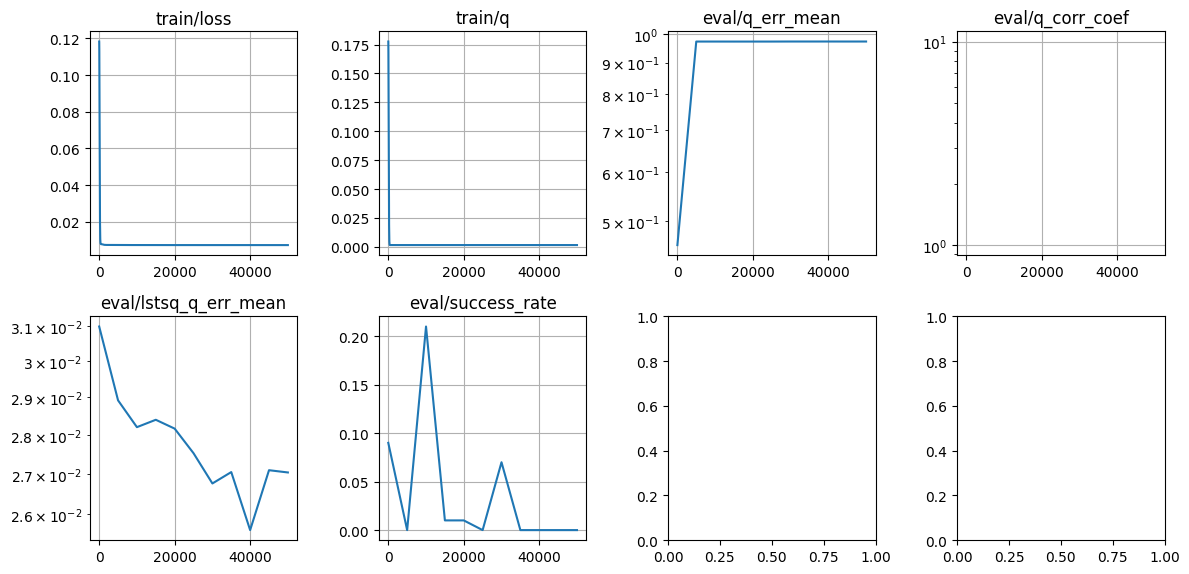

100%|██████████| 50000/50000 [02:05<00:00, 399.87it/s]


In [30]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2, p_curgoal=0.0, p_trajgoal=1.0)
critic = Critic(repr_dim=32)
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'], example_batch['next_observations'])

def loss_fn(params, batch):
  pos_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['goals'])
  neg_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['next_observations'])
  
  I = jnp.eye(batch_size)
  logits = I * pos_logits + (1 - I) * neg_logits
  loss = optax.sigmoid_binary_cross_entropy(logits=logits, labels=I).mean()
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             jnp.full_like(batch['observations'], (aug_env.nS - 2)))
  plus_probs = jnp.exp(jnp.diag(plus_logits)) * goal_marg[aug_env.nS - 2]
  q = (1 + discount) * plus_probs
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, opt_state, batch):
  (loss, info), grads = grad_fn(params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  return params, opt_state, loss, info

def compute_success_rate(params, num_eval_episodes=100, max_episode_steps=100):
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
  plus_logits = critic.apply(params, obs, actions, 
                             (aug_env.nS - 2) * jnp.ones_like(obs))
  plus_logits = jnp.diag(plus_logits)
  plus_logits = plus_logits.reshape([aug_env.nS, aug_env.nA])
  a = jnp.argmax(plus_logits, axis=-1)
  pi = jax.nn.one_hot(a, aug_env.nA)
  pi = np.asarray(pi)

  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=pi[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)

  return sr

def evaluate_fn(params):
  obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
  plus_logits = critic.apply(params, obs, actions, 
                             (aug_env.nS - 2) * jnp.ones_like(obs))
  plus_probs = jnp.exp(jnp.diag(plus_logits)) * goal_marg[aug_env.nS - 2]
  # q = (1 + discount) / discount * plus_probs
  q = (1 + discount) * plus_probs
  q = q.reshape([aug_env.nS, aug_env.nA])
  q = q[:env.nS]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size, p_curgoal=0.0, p_trajgoal=1.0)
  critic_params, opt_state, loss, info = update_fn(
    critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [31]:
crl_metrics = metrics
print(crl_metrics['eval/q_err_mean'][-1])
print(crl_metrics['eval/q_corr_coef'][-1])
print(crl_metrics['eval/lstsq_q_err_mean'][-1])
print(crl_metrics['eval/success_rate'][-1])

[5.00000000e+04 9.73498523e-01]
[ 5.00000000e+04 -3.91102582e-01]
[5.00000000e+04 2.70351078e-02]
[50000.     0.]


In [32]:
# evaluation the pi
obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)

plus_logits = critic.apply(critic_params, obs, actions, 
                           jnp.full_like(obs, (aug_env.nS - 2)))
plus_logits = jnp.diag(plus_logits)
plus_logits = plus_logits.reshape([aug_env.nS, aug_env.nA])
a = jnp.argmax(plus_logits, axis=-1)
pi = jax.nn.one_hot(a, aug_env.nA)
pi = np.asarray(pi)

print("pi: ")
print(pi[11])
print(pi[23])
print(pi[35])

pi: 
[0. 0. 0. 1.]
[0. 0. 0. 1.]
[1. 0. 0. 0.]


### SGC TD InfoNCE

In [33]:
class LogParam(nn.Module):
  """Scalar parameter module with log scale."""

  init_value: float = 1.0

  @nn.compact
  def __call__(self):
    log_value = self.param('log_value', init_fn=lambda key: jnp.full((), jnp.log(self.init_value)))
    return jnp.exp(log_value)

class Critic(nn.Module):
  repr_dim: int = 512
  log_temp: LogParam = LogParam()

  @nn.compact
  def __call__(self, obs, action, future_obs):
    obs = jax.nn.one_hot(obs, aug_env.nS)
    action = jax.nn.one_hot(action, aug_env.nA)
    future_obs = jax.nn.one_hot(future_obs, aug_env.nS)
    phi_inputs = jnp.concatenate([obs, action], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    phi = phi / jnp.linalg.norm(phi, axis=-1, keepdims=True) * jnp.sqrt(self.repr_dim)
    psi = psi / jnp.linalg.norm(psi, axis=-1, keepdims=True) * jnp.sqrt(self.repr_dim)
    logits = jnp.einsum('ik,jk->ij', phi, psi) / jnp.exp(self.log_temp())
    
    return logits

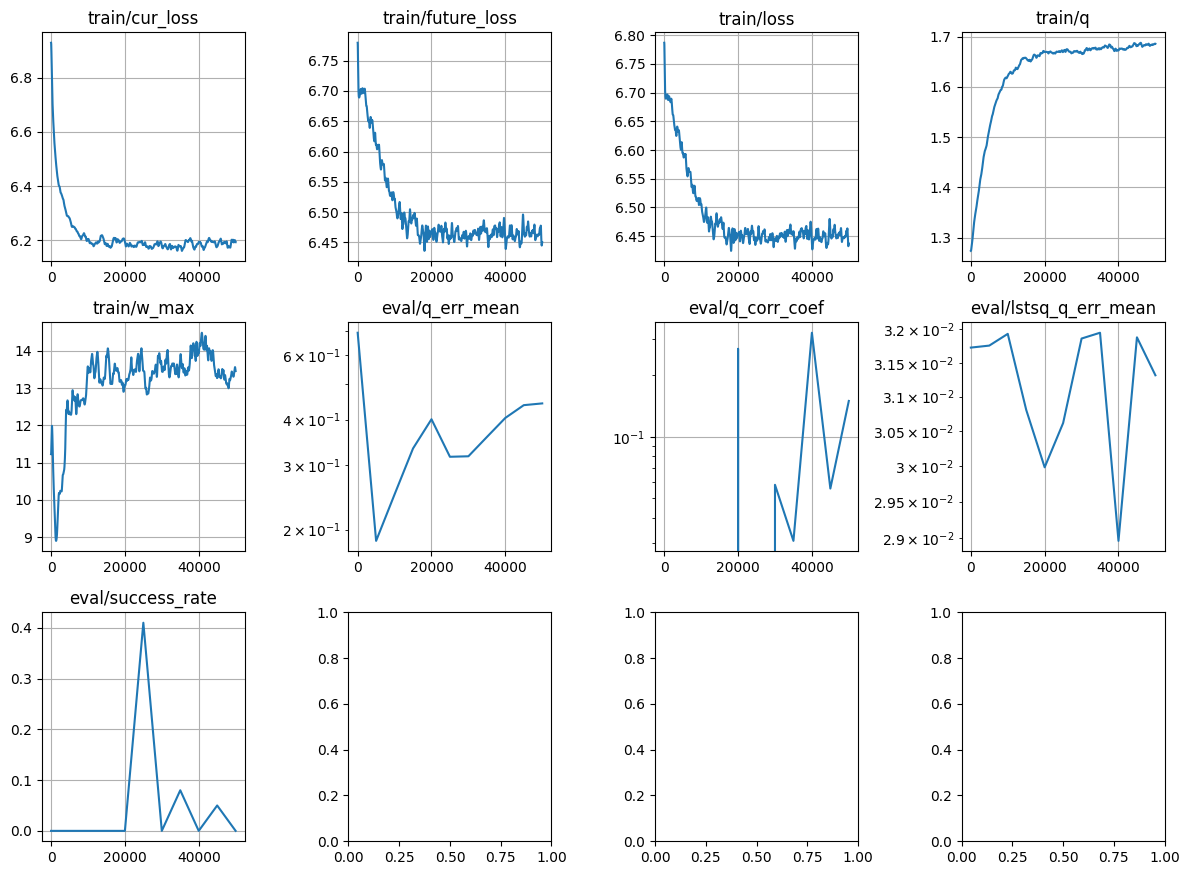

100%|██████████| 50000/50000 [03:39<00:00, 228.17it/s]


In [34]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

s_plus_marg = jnp.sum(aug_dataset['next_observations'] == aug_env.nS - 2) / len(aug_dataset['next_observations'])

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic(repr_dim=16)
critic_params = critic.init(critic_key, example_batch['observations'], example_batch['actions'], example_batch['next_observations'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['next_observations'])
  
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  random_logits = critic.apply(
    params, batch['observations'], batch['actions'], random_states)
  
  I = jnp.eye(batch_size)
  logits = I * logits + (1 - I) * random_logits
  cur_loss = optax.softmax_cross_entropy(logits=logits, labels=I)
  
  next_observations = batch['next_observations'][:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  next_actions = jnp.arange(aug_env.nA)[None, :].repeat(batch_size, axis=0).reshape(-1)
  # random_states = jnp.roll(batch['next_observations'], -1, axis=0)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  
  future_logit = critic.apply(
    params, next_observations, next_actions, random_states)
  plus_logits = critic.apply(params, next_observations, next_actions, 
                             jnp.full_like(next_observations, (aug_env.nS - 2)))
  I = jnp.eye(batch_size * aug_env.nA)
  # plus_logits = plus_logits * I + future_logit * (1 - I)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(future_logit, axis=-1)
  # plus_log_probs = jnp.diag(jax.nn.log_softmax(plus_logits, axis=-1))
  plus_log_probs = plus_log_probs.reshape([batch_size, aug_env.nA])
  next_actions = jnp.argmax(plus_log_probs, axis=-1)
  next_actions = jax.lax.stop_gradient(next_actions)
  
  # next_qs = critic.apply(target_params, next_observations, next_actions, goals)
  # next_qs = next_qs.reshape([batch_size, env.nA])
  # next_q = next_qs.max(axis=-1)
  
  # future_logit1 = critic.apply(
  #   target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), random_states)
  # future_logit2 = critic.apply(
  #   target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), random_states)
  # plus_logits1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), 
  #                             jnp.full_like(batch['observations'], (aug_env.nS - 2)))
  # plus_logits2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), 
  #                             jnp.full_like(batch['observations'], (aug_env.nS - 2)))
  # plus_log_probs1 = jnp.diag(plus_logits1) - jax.nn.logsumexp(future_logit1, axis=-1)
  # plus_log_probs2 = jnp.diag(plus_logits2) - jax.nn.logsumexp(future_logit2, axis=-1)
  # plus_log_probs = jnp.stack([plus_log_probs1, plus_log_probs2], axis=-1)
  # next_actions = jnp.argmax(plus_log_probs, axis=-1)
  # next_actions = jax.lax.stop_gradient(next_actions)
  
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  random_logits = critic.apply(
    params, batch['observations'], batch['actions'], random_states)
  
  w_logits = critic.apply(
    target_params, batch['next_observations'], next_actions, random_states)
  w = jax.nn.softmax(w_logits, axis=-1)
  # w = jax.lax.stop_gradient(w)
  w = jax.lax.stop_gradient(w) * batch_size * jnp.eye(batch_size)
  # w = jnp.clip(w, 0.0, 10.0)
  
  future_loss = optax.softmax_cross_entropy(logits=random_logits, labels=w)
  
  loss = (1 - discount) * cur_loss + discount * future_loss
  loss = jnp.mean(loss)
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             jnp.full_like(batch['observations'], (aug_env.nS - 2)))
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  # scaled_probs = discount * probs + (1 - discount) * indicators[batch['observations'], batch['actions']]
  q = probs * (1 + discount)
  
  info = {
    'loss': loss,
    'cur_loss': cur_loss.mean(),
    'future_loss': future_loss.mean(),
    'w_max': w.max(),
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
# optimizer = optax.adamw(learning_rate=5e-5, weight_decay=1e-2, b1=0.9, b2=0.95)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, batch, num_eval_episodes=100, max_episode_steps=100):
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions, 
                             (aug_env.nS - 2) * jnp.ones_like(random_states))
  random_logits = critic.apply(params, obs, actions, random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_log_probs = plus_log_probs.reshape([aug_env.nS, aug_env.nA])
  
  a = jnp.argmax(plus_log_probs, axis=-1)
  pi = jax.nn.one_hot(a, aug_env.nA)
  pi = np.asarray(pi)
  
  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=pi[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)

  return sr

def evaluate_fn(params, batch):
  obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions, 
                             jnp.full_like(random_states, (aug_env.nS - 2)))
  random_logits = critic.apply(params, obs, actions, random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  plus_probs = plus_probs.reshape([aug_env.nS, aug_env.nA])
  # scaled_plus_probs = discount * plus_probs + (1 - discount) * indicators
  q = plus_probs * (1 + discount)
  q = q[:env.nS]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params, batch)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params, batch)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [35]:
sgc_td_infonce_metrics = metrics
print(sgc_td_infonce_metrics['eval/q_err_mean'][-1])
print(sgc_td_infonce_metrics['eval/q_corr_coef'][-1])
print(sgc_td_infonce_metrics['eval/lstsq_q_err_mean'][-1])
print(sgc_td_infonce_metrics['eval/success_rate'][-1])

[5.00000000e+04 4.43123639e-01]
[5.00000000e+04 1.49795711e-01]
[5.00000000e+04 3.13142687e-02]
[50000.     0.]


In [36]:
# evaluation the pi
batch = sample_augmented_batch(batch_size)

obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
random_states = jnp.roll(batch['observations'], -1, axis=0)
plus_logits = critic.apply(critic_params, obs, actions, 
                            (aug_env.nS - 2) * jnp.ones_like(random_states))
random_logits = critic.apply(critic_params, obs, actions, random_states)
plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
plus_log_probs = plus_log_probs.reshape([aug_env.nS, aug_env.nA])

a = jnp.argmax(plus_log_probs, axis=-1)
pi = jax.nn.one_hot(a, aug_env.nA)
pi = np.asarray(pi)

print("pi: ")
print(pi[11])
print(pi[23])
print(pi[35])

pi: 
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[1. 0. 0. 0.]


### GC TD InfoNCE

In [37]:
class LogParam(nn.Module):
  """Scalar parameter module with log scale."""

  init_value: float = 1.0

  @nn.compact
  def __call__(self):
    log_value = self.param('log_value', init_fn=lambda key: jnp.full((), jnp.log(self.init_value)))
    return log_value

class Critic(nn.Module):
  repr_dim: int = 512
  log_temp: LogParam = LogParam()

  @nn.compact
  def __call__(self, obs, action, goals, future_obs):
    obs = jax.nn.one_hot(obs, aug_env.nS)
    action = jax.nn.one_hot(action, aug_env.nA)
    goals = jax.nn.one_hot(goals, aug_env.nS)
    future_obs = jax.nn.one_hot(future_obs, aug_env.nS)
    phi_inputs = jnp.concatenate([obs, action, goals], axis=-1)
    psi_inputs = future_obs

    phi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(phi_inputs)
    psi = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])(psi_inputs)
    
    phi = phi / jnp.linalg.norm(phi, axis=-1, keepdims=True) * jnp.sqrt(self.repr_dim)
    psi = psi / jnp.linalg.norm(psi, axis=-1, keepdims=True) * jnp.sqrt(self.repr_dim)
    logits = jnp.einsum('ik,jk->ij', phi, psi) / jnp.exp(self.log_temp())
    
    return logits

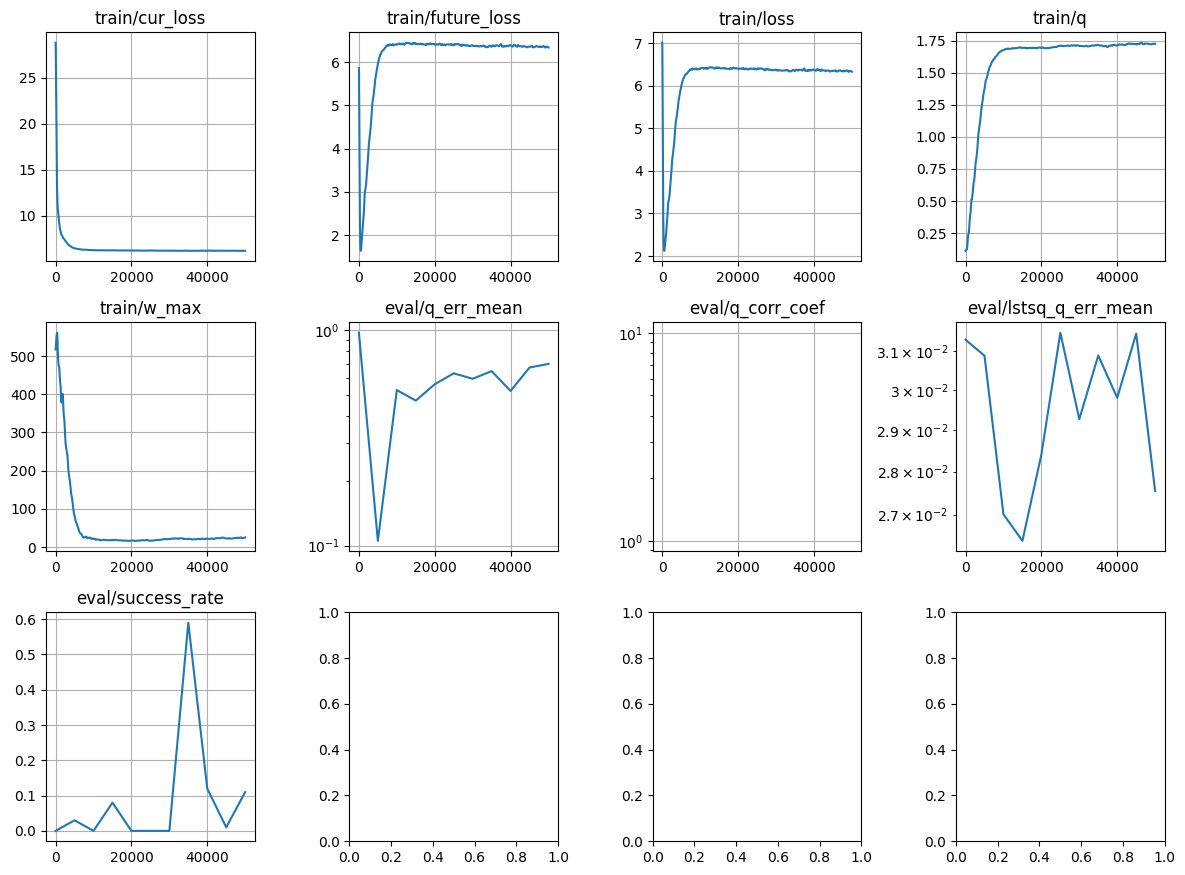

100%|██████████| 50000/50000 [03:58<00:00, 209.88it/s]


In [ ]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

s_plus_marg = jnp.sum(aug_dataset['next_observations'] == aug_env.nS - 2) / len(aug_dataset['next_observations'])

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_augmented_batch(2)
critic = Critic(repr_dim=128)
critic_params = critic.init(critic_key, 
                            example_batch['observations'], example_batch['actions'], 
                            example_batch['goals'], example_batch['next_observations'])
target_critic_params = copy.deepcopy(critic_params)

def loss_fn(params, target_params, batch):
  logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['goals'], batch['next_observations'])
  
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  random_logits = critic.apply(
    params, batch['observations'], batch['actions'], batch['goals'], random_states)
  
  I = jnp.eye(batch_size)
  logits = I * logits + (1 - I) * random_logits
  cur_loss = optax.softmax_cross_entropy(logits=logits, labels=I)
  
  # future_logit1 = critic.apply(
  #   target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), batch['goals'], random_states)
  # future_logit2 = critic.apply(
  #   target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), batch['goals'], random_states)
  # plus_logits1 = critic.apply(target_params, batch['next_observations'], jnp.zeros_like(batch['next_observations']), 
  #                             batch['goals'], batch['goals'])
  # plus_logits2 = critic.apply(target_params, batch['next_observations'], jnp.ones_like(batch['next_observations']), 
  #                             batch['goals'], batch['goals'])
  # plus_log_probs1 = jnp.diag(plus_logits1) - jax.nn.logsumexp(future_logit1, axis=-1)
  # plus_log_probs2 = jnp.diag(plus_logits2) - jax.nn.logsumexp(future_logit2, axis=-1)
  # plus_log_probs = jnp.stack([plus_log_probs1, plus_log_probs2], axis=-1)
  # next_actions = jnp.argmax(plus_log_probs, axis=-1)
  # next_actions = jax.lax.stop_gradient(next_actions)
  next_observations = batch['next_observations'][:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  next_actions = jnp.arange(aug_env.nA)[None, :].repeat(batch_size, axis=0).reshape(-1)
  goals = batch['goals'][:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  
  future_logit = critic.apply(
    target_params, next_observations, next_actions, goals, random_states)
  plus_logits = critic.apply(target_params, next_observations, next_actions, 
                             goals, goals)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(future_logit, axis=-1)
  plus_log_probs = plus_log_probs.reshape([batch_size, aug_env.nA])
  next_actions = jnp.argmax(plus_log_probs, axis=-1)
  next_actions = jax.lax.stop_gradient(next_actions)
  
  w_logits = critic.apply(
    target_params, batch['next_observations'], next_actions, batch['goals'], random_states)
  w = jax.nn.softmax(w_logits, axis=-1)
  w = jax.lax.stop_gradient(w) * batch_size * I
  # w = jnp.clip(w, 0.0, 100.0 / batch_size)
  
  future_loss = optax.softmax_cross_entropy(logits=random_logits, labels=w)
  
  loss = (1 - discount) * cur_loss + discount * future_loss
  loss = jnp.mean(loss)
  
  plus_logits = critic.apply(params, batch['observations'], batch['actions'], 
                             jnp.full_like(batch['observations'], (aug_env.nS - 2)),
                             jnp.full_like(batch['observations'], (aug_env.nS - 2)))
  random_logits = critic.apply(params, batch['observations'], batch['actions'],
                               jnp.full_like(batch['observations'], (aug_env.nS - 2)),
                               random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  # scaled_probs = discount * probs + (1 - discount) * indicators[batch['observations'], batch['actions']]
  q = probs * (1 + discount)
  
  info = {
    'loss': loss,
    'cur_loss': cur_loss.mean(),
    'future_loss': future_loss.mean(),
    'w_max': w.max(),
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state, params)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * (1 - tau),
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

def compute_success_rate(params, batch, num_eval_episodes=100, max_episode_steps=100):
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  # compute the pi
  obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions, 
                             jnp.full_like(obs, (aug_env.nS - 2)),
                             jnp.full_like(obs, (aug_env.nS - 2)))
  random_logits = critic.apply(params, obs, actions, 
                               jnp.full_like(obs, (aug_env.nS - 2)),
                               random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_log_probs = plus_log_probs.reshape([aug_env.nS, aug_env.nA])
  
  a = jnp.argmax(plus_log_probs, axis=-1)
  pi = jax.nn.one_hot(a, aug_env.nA)
  pi = np.asarray(pi)
  
  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=pi[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)

  return sr

def evaluate_fn(params, batch):
  obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
  actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
  random_states = jnp.roll(batch['next_observations'], -1, axis=0)
  plus_logits = critic.apply(params, obs, actions,
                             (aug_env.nS - 2) * jnp.ones_like(obs), 
                             (aug_env.nS - 2) * jnp.ones_like(obs))
  random_logits = critic.apply(params, obs, actions, 
                               (aug_env.nS - 2) * jnp.ones_like(obs),
                               random_states)
  plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
  plus_probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
  plus_probs = plus_probs.reshape([aug_env.nS, aug_env.nA])
  # scaled_plus_probs = discount * plus_probs + (1 - discount) * indicators
  q = plus_probs * (1 + discount)
  q = q[:env.nS]
  
  slopes, intercepts = jnp.linalg.lstsq(
    jnp.stack([q.reshape(-1), jnp.ones_like(q.reshape(-1))], axis=1), 
    opt_q_square_discount.reshape(-1)
  )[0]
  lstsq_q = slopes * q + intercepts
  
  q_err_mean = jnp.mean(np.abs(q - opt_q_square_discount))
  q_corr_coef = jnp.corrcoef(q.reshape(-1), opt_q_square_discount.reshape(-1))[0, 1]
  lstsq_q_err_mean = jnp.mean(np.abs(lstsq_q - opt_q_square_discount))
  
  sr = compute_success_rate(params, batch)
  
  info = {
    'q_err_mean': q_err_mean,
    'q_corr_coef': q_corr_coef,
    'lstsq_q_err_mean': lstsq_q_err_mean,
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(critic_params, batch)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=['eval/q_err_mean', 'eval/lstsq_q_err_mean', 'eval/q_corr_coef'])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


In [39]:
td_infonce_metrics = metrics
print(td_infonce_metrics['eval/q_err_mean'][-1])
print(td_infonce_metrics['eval/q_corr_coef'][-1])
print(td_infonce_metrics['eval/lstsq_q_err_mean'][-1])
print(td_infonce_metrics['eval/success_rate'][-1])

[5.00000000e+04 6.97829962e-01]
[ 5.00000000e+04 -3.71611178e-01]
[5.00000000e+04 2.75404193e-02]
[5.0e+04 1.1e-01]


In [55]:
# evaluation the pi
batch = sample_augmented_batch(batch_size)

obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
random_states = jnp.roll(batch['next_observations'], -1, axis=0)
plus_logits = critic.apply(critic_params, obs, actions, 
                           jnp.full_like(obs, (aug_env.nS - 2)), 
                           jnp.full_like(random_states, (aug_env.nS - 2)))
random_logits = critic.apply(critic_params, obs, actions, 
                             jnp.full_like(obs, (aug_env.nS - 2)), 
                             random_states)
plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
plus_log_probs = plus_log_probs.reshape([aug_env.nS, aug_env.nA])

a = jnp.argmax(plus_log_probs, axis=-1)
pi = jax.nn.one_hot(a, aug_env.nA)
pi = np.asarray(pi)

print("pi: ")
print(pi[11])
print(pi[23])
print(pi[35])

pi: 
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]


### QRL

In [68]:
class LogParam(nn.Module):
  """Scalar parameter module with log scale."""

  init_value: float = 1.0

  @nn.compact
  def __call__(self):
    log_value = self.param('log_value', init_fn=lambda key: jnp.full((), jnp.log(self.init_value)))
    return log_value

class MRNValue(nn.Module):
  repr_dim: int = 512

  @nn.compact
  def __call__(self, obs, goals):
    obs = jax.nn.one_hot(obs, aug_env.nS)
    goals = jax.nn.one_hot(goals, aug_env.nS)

    phi_net = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.Dense(512),
      nn.gelu,
      nn.Dense(self.repr_dim),
    ])
    
    phi_s = phi_net(obs)
    phi_g = phi_net(goals)
    
    sym_s = phi_s[..., : self.repr_dim // 2]
    sym_g = phi_g[..., : self.repr_dim // 2]
    asym_s = phi_s[..., self.repr_dim // 2:]
    asym_g = phi_g[..., self.repr_dim // 2:]
    squared_dist = ((sym_s - sym_g) ** 2).sum(axis=-1)
    quasi = jax.nn.relu((asym_s - asym_g).max(axis=-1))
    v = jnp.sqrt(jnp.maximum(squared_dist, 1e-12)) + quasi

    return v

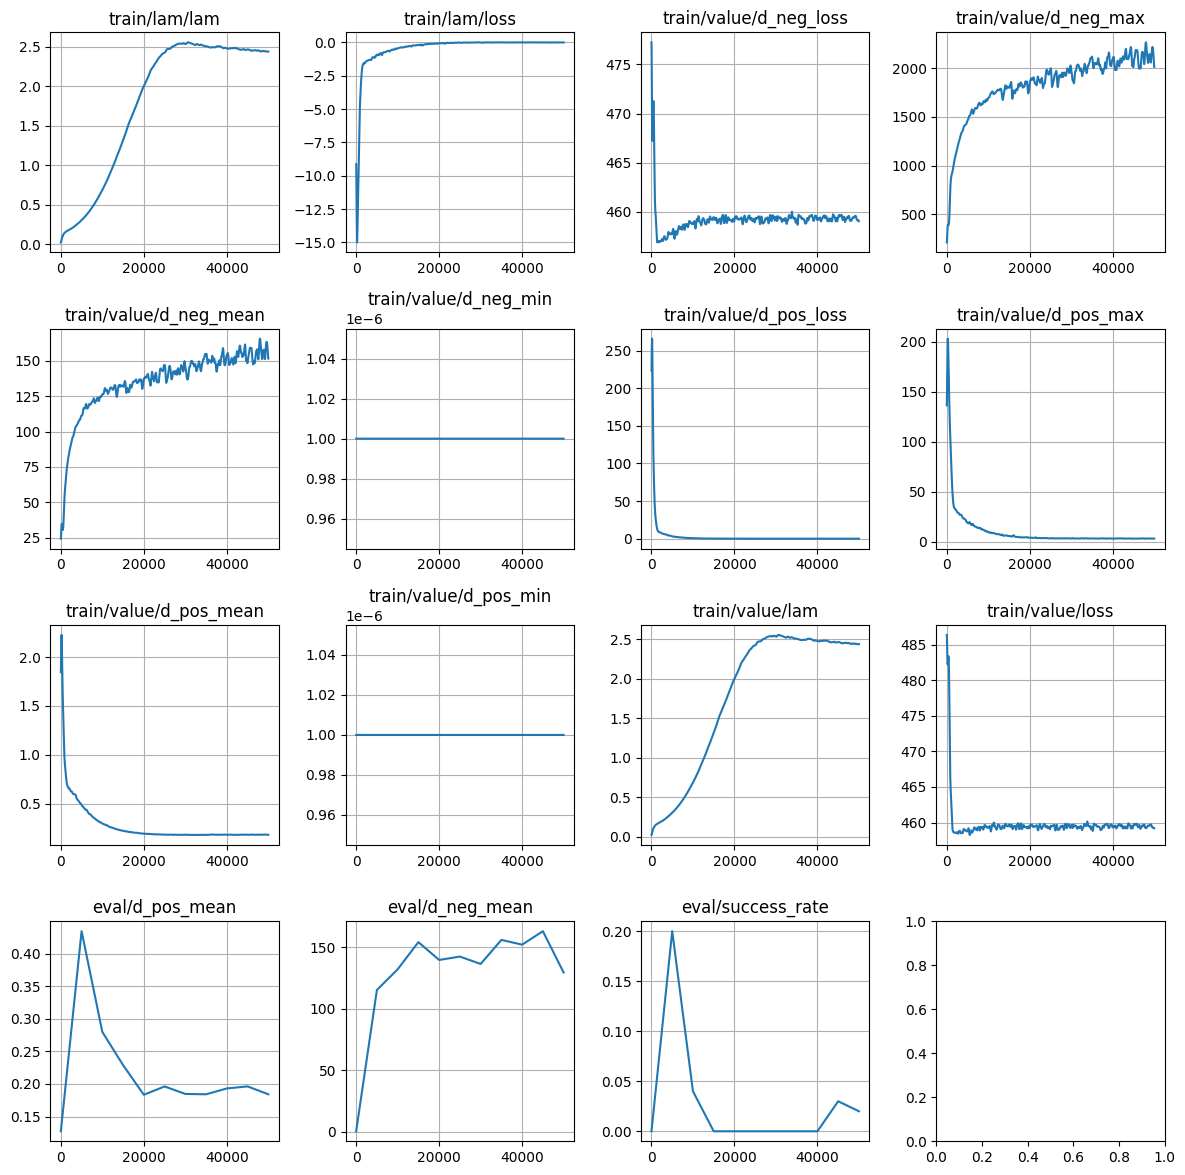

100%|██████████| 50000/50000 [02:49<00:00, 294.83it/s]


In [69]:
batch_size = 1024
tau = 0.005
eps=0.05  # Margin for the dual lambda loss.
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

transition_probs = jnp.asarray(aug_env.aug_transition_probs)

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, quasi_value_key, log_lam_key = jax.random.split(key, 3)

example_batch = sample_augmented_batch(2)
quasi_value = MRNValue()
log_lam = LogParam()
quasi_value_params = quasi_value.init(quasi_value_key, example_batch['observations'], example_batch['goals'])
log_lam_params = log_lam.init(log_lam_key)

def value_loss_fn(value_params, lam_params, batch):
    d_neg = quasi_value.apply(value_params, batch['observations'], batch['goals'])
    d_pos = quasi_value.apply(value_params, batch['observations'], batch['next_observations'])
    lam = log_lam.apply(lam_params)
    
    # Apply loss shaping following the original implementation.
    d_neg_loss = (100 * jax.nn.softplus(5 - d_neg / 100)).mean()
    d_pos_loss = (jax.nn.relu(d_pos - 1) ** 2).mean()

    loss = d_neg_loss + d_pos_loss * jax.lax.stop_gradient(lam)
    
    info = {
        'loss': loss,
        # 'value_loss': value_loss,
        # 'lam_loss': lam_loss,
        'd_neg_loss': d_neg_loss,
        'd_neg_mean': d_neg.mean(),
        'd_neg_max': d_neg.max(),
        'd_neg_min': d_neg.min(),
        'd_pos_loss': d_pos_loss,
        'd_pos_mean': d_pos.mean(),
        'd_pos_max': d_pos.max(),
        'd_pos_min': d_pos.min(),
        'lam': lam,
    }
    
    return loss, info

def lam_loss_fn(lam_params, value_params, batch):
  d_pos = quasi_value.apply(value_params, batch['observations'], batch['next_observations'])
  lam = log_lam.apply(lam_params)
  
  d_pos_loss = (jax.nn.relu(d_pos - 1) ** 2).mean()
  loss = lam * (eps - jax.lax.stop_gradient(d_pos_loss))
  
  info = {
    'loss': loss,
    'lam': lam,
  }
  
  return loss, info

value_optimizer = optax.adam(learning_rate=3e-4)
lam_optimizer = optax.adam(learning_rate=3e-4)
value_opt_state = value_optimizer.init(quasi_value_params)
lam_opt_state = lam_optimizer.init(log_lam_params)
value_grad_fn = jax.value_and_grad(value_loss_fn, has_aux=True)
lam_grad_fn = jax.value_and_grad(lam_loss_fn, has_aux=True)

@jax.jit
def update_fn(value_params, lam_params, value_opt_state, lam_opt_state, batch):
  (_, value_info), value_grads = value_grad_fn(value_params, lam_params, batch)
  (_, lam_info), lam_grads = lam_grad_fn(lam_params, value_params, batch)
  
  value_updates, value_opt_state = value_optimizer.update(value_grads, value_opt_state, value_params)
  value_params = optax.apply_updates(value_params, value_updates)
  lam_updates, lam_opt_state = lam_optimizer.update(lam_grads, lam_opt_state, lam_params)
  lam_params = optax.apply_updates(lam_params, lam_updates)
  
  info = dict()
  for k, v in value_info.items():
    info['value/' + k] = v
    
  for k, v in lam_info.items():
    info['lam/' + k] = v
  
  return value_params, lam_params, value_opt_state, lam_opt_state, info

def compute_success_rate(params, batch, num_eval_episodes=100, max_episode_steps=100):
  eval_env = CliffWalkingEnv(random_init_state=True, max_episode_steps=max_episode_steps)
  
  # compute the pi
  next_obs = jnp.arange(aug_env.nS)
  goals = jnp.full_like(next_obs, (aug_env.nS - 2))
  
  next_d = quasi_value.apply(params, next_obs, goals)
  d = jnp.sum(transition_probs * next_d[None, None], axis=-1)
  
  a = jnp.argmin(d, axis=-1)
  pi = jax.nn.one_hot(a, aug_env.nA)
  pi = np.asarray(pi)
  
  # evaluation
  successes = []
  for _ in tqdm.trange(num_eval_episodes):
    traj_dataset = defaultdict(list)

    done = False
    obs, _ = eval_env.reset()
    while not done:
      action = np.random.choice(np.arange(eval_env.nA), p=pi[obs])
      next_obs, reward, terminated, truncated, _ = eval_env.step(action)
      done = terminated or truncated
      
      traj_dataset['observations'].append(obs)
      traj_dataset['actions'].append(action)
      traj_dataset['rewards'].append(reward)
      traj_dataset['next_observations'].append(next_obs)
      
      obs = next_obs
    successes.append(47 in traj_dataset['next_observations'])
  sr = np.mean(successes)

  return sr

def evaluate_fn(params, batch):
#   obs = jnp.arange(aug_env.nS)[:, None].repeat(aug_env.nA, axis=1).reshape(-1)
#   actions = jnp.arange(aug_env.nA)[None, :].repeat(aug_env.nS, axis=0).reshape(-1)
#   random_states = jnp.roll(batch['next_observations'], -1, axis=0)
#   plus_logits = critic.apply(params, obs, actions,
#                              (aug_env.nS - 2) * jnp.ones_like(obs), 
#                              (aug_env.nS - 2) * jnp.ones_like(obs))
#   random_logits = critic.apply(params, obs, actions, 
#                                (aug_env.nS - 2) * jnp.ones_like(obs),
#                                random_states)
#   plus_log_probs = jnp.diag(plus_logits) - jax.nn.logsumexp(random_logits, axis=-1)
#   plus_probs = jnp.exp(plus_log_probs) * batch_size * s_plus_marg
#   plus_probs = plus_probs.reshape([aug_env.nS, aug_env.nA])
#   # scaled_plus_probs = discount * plus_probs + (1 - discount) * indicators
#   q = plus_probs * (1 + discount)
#   q = q[:env.nS]

  d_pos = quasi_value.apply(params, batch['observations'], batch['next_observations'])
  d_neg = quasi_value.apply(params, batch['observations'], batch['goals'])
  
  sr = compute_success_rate(params, batch)
  
  info = {
    'd_pos_mean': d_pos.mean(),
    'd_neg_mean': d_neg.mean(),
    'success_rate': sr,
  }
  
  return info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_augmented_batch(batch_size)
  quasi_value_params, log_lam_params, value_opt_state, lam_opt_state, info = update_fn(
    quasi_value_params, log_lam_params, value_opt_state, lam_opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array([i, v])
    )

  if i == 1 or i % eval_interval == 0:
    eval_info = evaluate_fn(quasi_value_params, batch)
    for k, v in eval_info.items():
      metrics['eval/' + k].append(
        np.array([i, v])
      )

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=[])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()
